In [1]:
%matplotlib inline
import numpy as np
import lib.io.stan
import lib.syn_data
import matplotlib.pyplot as plt
import os

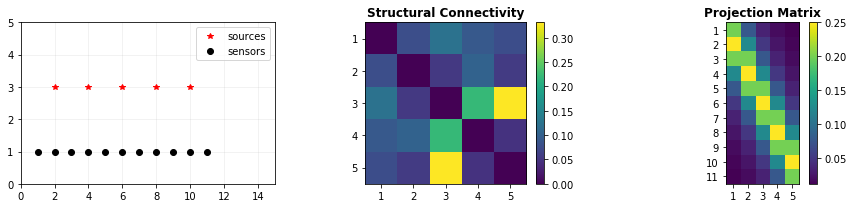

In [2]:
results_dir = 'results/exp7'
os.makedirs(f'{results_dir}/figures',exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
np.random.seed(0)

x = np.r_[2:12:2]
y = np.repeat(np.array([3.0]),np.size(x))
src_locs = np.array(list(zip(x,y)))
nNodes = np.size(src_locs,0)
x = np.r_[1:12:1]
y = np.repeat(np.array([1.0]),np.size(x))
snsr_locs = np.array(list(zip(x,y)))
nSnsrs = np.size(snsr_locs,0)


plt.figure(figsize=[12,3])
plt.subplot(131)
plt.plot(src_locs[:,0],src_locs[:,1],'r*',label='sources')
plt.plot(snsr_locs[:,0],snsr_locs[:,1],'ko',label='sensors')
plt.xlim([0,15])
plt.ylim([0,5])
plt.grid(1,alpha=0.2)
plt.legend(loc='upper right')

ax = plt.subplot(132)
SC = lib.syn_data.gen_con(nNodes)

im = plt.imshow(SC)
plt.xticks(np.arange(0,nNodes),map(str,np.arange(1,nNodes+1)))
plt.yticks(np.arange(0,nNodes),map(str,np.arange(1,nNodes+1)))
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title("Structural Connectivity",fontweight="bold")

proj_mat = lib.syn_data.comp_proj_mat(src_locs,snsr_locs)

plt.subplot(133)
plt.imshow(proj_mat)
plt.xticks(np.arange(0,nNodes),map(str,np.arange(1,nNodes+1)))
plt.yticks(np.arange(0,nSnsrs),map(str,np.arange(1,nSnsrs+1)))
plt.colorbar(fraction=0.046,pad=0.04)
plt.gca().set_title("Projection Matrix",fontweight="bold")

plt.tight_layout()
plt.savefig(f'{results_dir}/figures/network.png')


np.savez(f'{results_dir}/network.npz', src_locs=src_locs, snsr_locs = snsr_locs, \
        SC=SC, proj_mat=proj_mat)

In [7]:
nn = nNodes
ns = nSnsrs
I1 = 3.1
tau0 = 30.0
k = 2.0
Ic = np.zeros(nn)

x0 = -2.5*np.ones(nn)
x0[2] = -1.8
x0[4] = -2.2
time_scale = 1.0
time_step = 0.1
sigma = 0.01
nt = 50*int(1/time_step)
epsilon = 0.1
amplitude = 1.0
offset = 0.0

x_init = -0.5*np.ones(nn)
z_init = 1.5*np.ones(nn)
z_eta = np.random.normal(0.0, 1.0, [nt-1, nn])

data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'tau0':tau0, 'Ic':Ic, 'SC':SC, 
        'gain': proj_mat, 'sigma':sigma, 'k':k, 'epsilon': epsilon, 'amplitude': amplitude,
        'offset': offset, 'x0':x0, 'time_scale':time_scale, 'time_step':time_step,
        'x_init':x_init, 'z_init':z_init, 'z_eta': z_eta}

lib.io.stan.rdump(f'{results_dir}/sim_data.R',data)

stan_fname = './vep-src-infer-sim'
lib.io.stan.create_process(['bash','/home/anirudhnihalani/scripts/stancompile.sh', stan_fname],block=True)
sim_cmd = f'{stan_fname} sample algorithm=fixed_param num_samples=1 num_warmup=0 data \
file={results_dir}/sim_data.R output file={results_dir}/sim_out.csv'
lib.io.stan.create_process(sim_cmd.split(),block=True)

/home/anirudhnihalani/vep.stan

--- Translating Stan model to C++ code ---
bin/stanc  /home/anirudhnihalani/vep.stan/./vep-src-infer-sim.stan --o=/home/anirudhnihalani/vep.stan/./vep-src-infer-sim.hpp
Model name=vep_src_infer_sim_model
Input file=/home/anirudhnihalani/vep.stan/./vep-src-infer-sim.stan
Output file=/home/anirudhnihalani/vep.stan/./vep-src-infer-sim.hpp

--- Linking C++ model ---
g++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.64.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -I src -I stan/src -isystem stan/lib/stan_math/ -DEIGEN_NO_DEBUG -DFUSION_MAX_VECTOR_SIZE=12 -DNO_FPRINTF_OUTPUT -pipe -lpthread  -O3 -o /home/anirudhnihalani/vep.stan/./vep-src-infer-sim src/cmdstan/main.cpp -include /home/anirudhnihalani/vep.stan/./vep-src-infer-sim.hpp stan/lib/stan_math/lib/cvodes_2.9.0/lib/libsundials_n

0

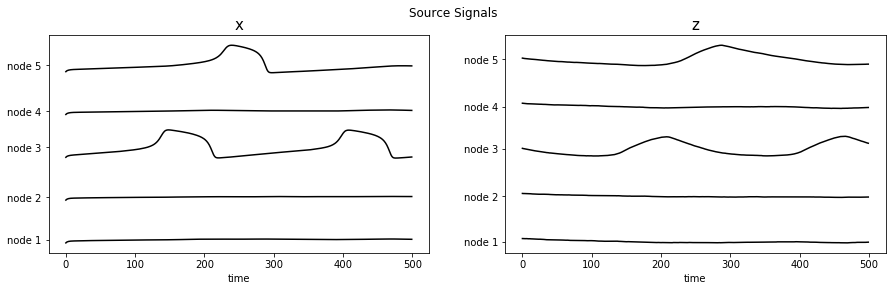

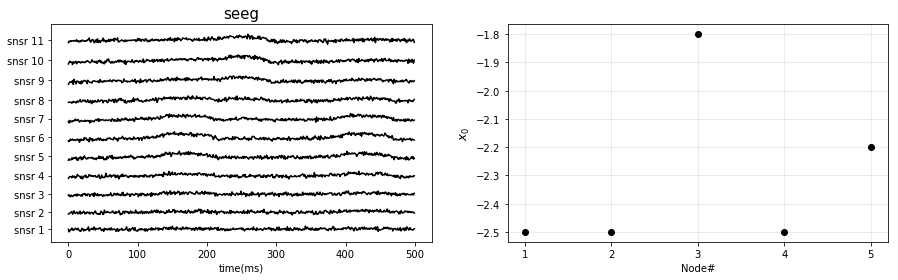

In [13]:
t = lib.io.stan.parse_csv(f'{results_dir}/sim_out.csv')

x = t['x'][0]
z = t['z'][0]
seeg = t['seeg'][0]

plt.figure(figsize=[15,4])
plt.subplot(121)
for i in range(nn):
    plt.plot(x.T[:,i]/4.0 + i,label=f'node{i+1}',color='black')
plt.yticks(np.mean(x.T/4.0 + np.arange(nn),axis=0), map(lambda x: f'node {x}',np.arange(1,nn+1)))
plt.xlabel('time')
plt.gca().set_title('x',fontsize=15.0)
plt.suptitle('Source Signals')
plt.subplot(122)
for i in range(nn):
    plt.plot(z.T[:,i]/4.0 + i,label=f'node{i}',color='black')
plt.yticks(np.mean(z.T/4.0 + np.arange(nn),axis=0), map(lambda x: f'node {x}',np.arange(1,nn+1)))
plt.xlabel('time')
plt.gca().set_title('z',fontsize=15.0)
plt.savefig(f'{results_dir}/figures/src_signals.png')

plt.figure(figsize=[15,4])
plt.subplot(1,2,1)
plt.plot(seeg.T + np.r_[0:2*ns:2],'k')
plt.yticks(np.mean(seeglp.T + np.r_[0:2*ns:2],axis=0), map(lambda x: f'snsr {x}',np.arange(1,ns+1)))
plt.xlabel('time(ms)')
plt.title('seeg',fontsize=15.0)
plt.subplot(1,2,2)
plt.plot(np.r_[1:nn+1],x0,'ko')
plt.xlabel('Node#')
plt.xticks(np.arange(1,nn+1),map(str,np.arange(1,nn+1)))
plt.ylabel('$x_0$',fontsize=12.0)
plt.grid(alpha=0.3)
plt.savefig(f'{results_dir}/figures/seeg.png')

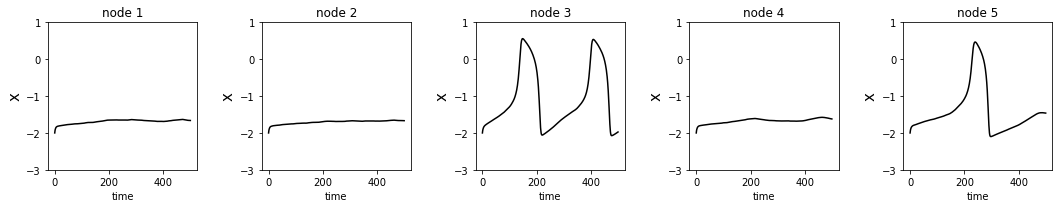

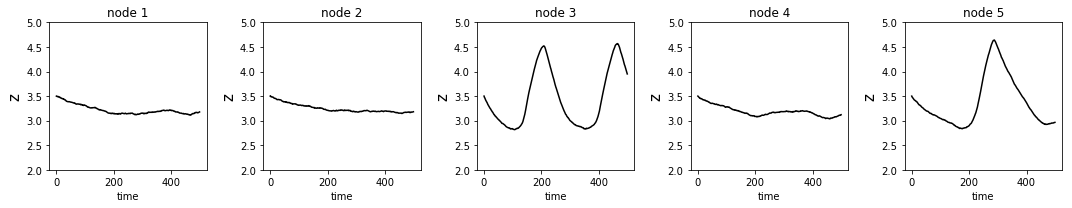

In [11]:
plt.figure(figsize=[15,3])
for i in range(nn):
    plt.subplot(1,5,i+1)
    plt.plot(x[i,:],'k')
    plt.xlabel('time')
    plt.ylabel('x',fontsize=15.0)
    plt.ylim([-3.0,1.0])
    plt.gca().set_title(f'node {i+1}')
plt.savefig(f'{results_dir}/figures/src_signals_2.png')    
    
plt.tight_layout()
plt.figure(figsize=[15,3])
for i in range(nn):
    plt.subplot(1,5,i+1)
    plt.plot(z[i,:],'k')
    plt.xlabel('time')
    plt.ylabel('z',fontsize=15.0)
    plt.ylim([2.0,5.0])
    plt.gca().set_title(f'node {i+1}')
plt.tight_layout()
plt.savefig(f'{results_dir}/figures/src_signals_3.png')

In [23]:
sim_data = lib.io.stan.rload(f'{results_dir}/sim_data.R')
data = {'ns':sim_data['ns'], 'nn':sim_data['nn'], 'nt':sim_data['nt'],
        'gain':sim_data['gain'], 'epsilon':sim_data['epsilon'], 'seeg':seeg.T}    
    
lib.io.stan.rdump(f'{results_dir}/fit_data.R',data)

stan_fname = './vep-src-infer'
lib.io.stan.create_process(['bash','/home/anirudhnihalani/scripts/stancompile.sh', stan_fname],block=True)

nchains = 8
with open('vep-src-infer.sh','r') as fd:
    slurm_script = fd.read().format(results_dir,nchains)
with open('tmp/vep-src-infer.sh','w') as fd:
    fd.write(slurm_script)
lib.io.stan.create_process(['sbatch','tmp/vep-src-infer.sh'],block=False)


/home/anirudhnihalani/vep.stan
make: `/home/anirudhnihalani/vep.stan/./vep-src-infer' is up to date.


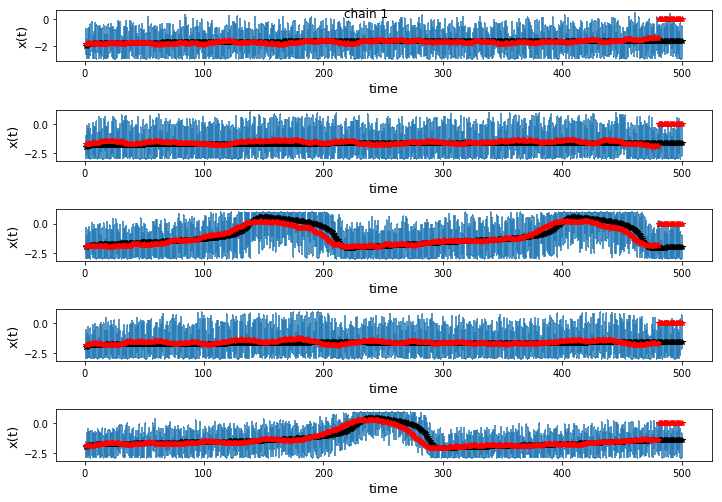

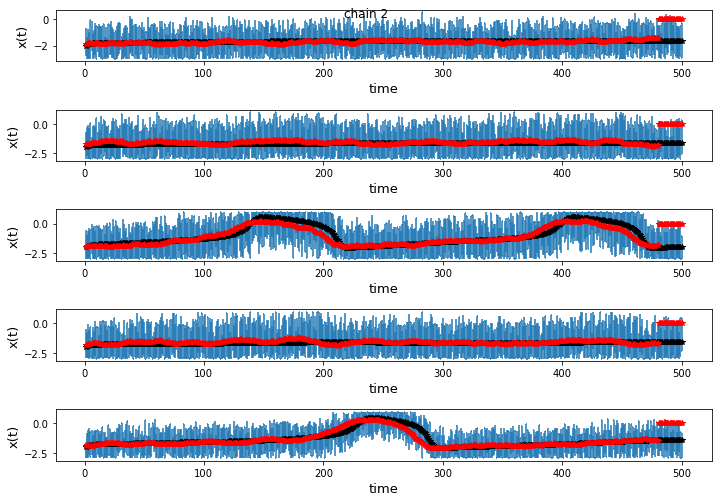

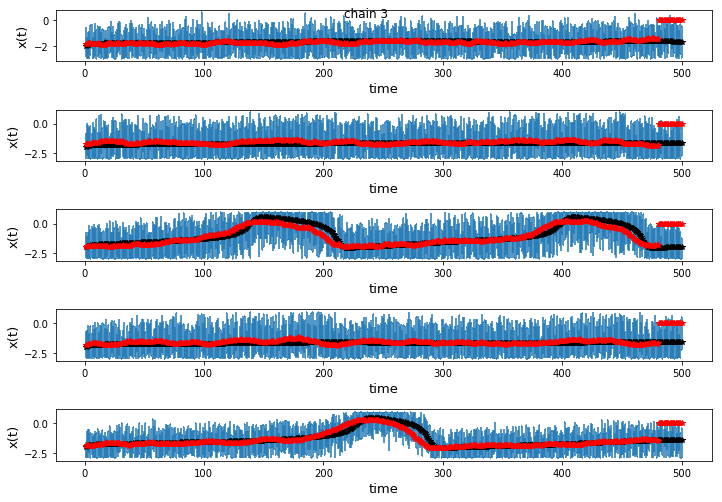

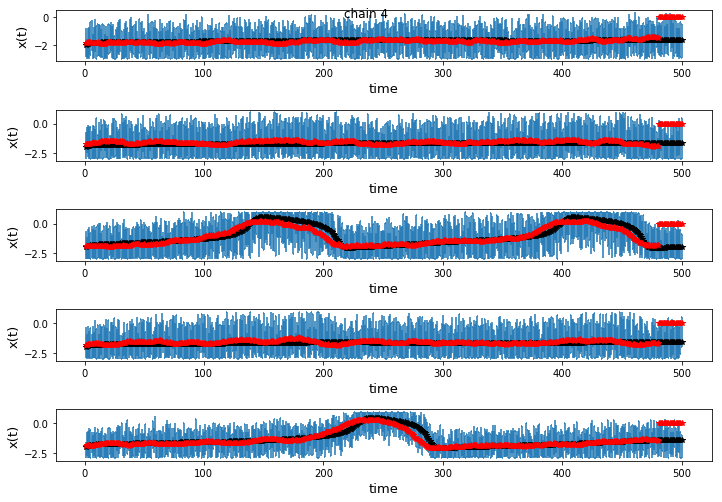

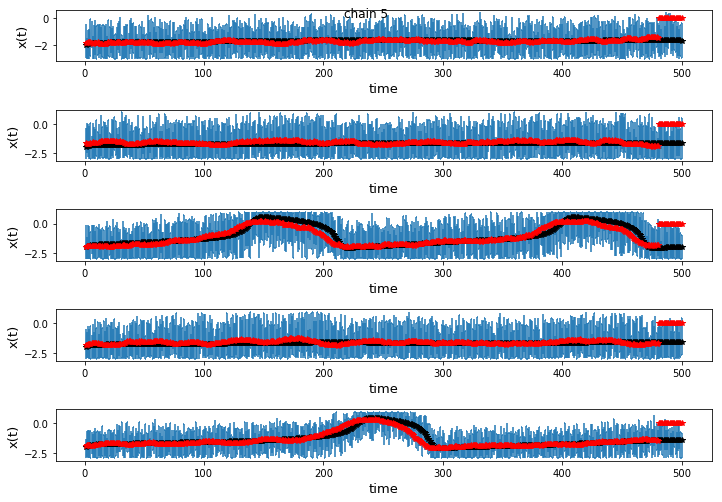

In [ ]:
def mov_avg(x,win_size):
    y = np.zeros(len(x))
    for i in range(len(x)-win_size):
        y[i] = np.mean(x[i:i+win_size])
    return y

sim_data = lib.io.stan.rload(f'{results_dir}/sim_data.R')
sim_out = lib.io.stan.parse_csv(f'{results_dir}/sim_out.csv')
chains = [1,2,3,4,5,6,7,8]
for i,chain_no in enumerate(chains):
    t = lib.io.stan.parse_csv(f'{results_dir}/samples_chain{chain_no}.csv')
    plt.figure(figsize=[10,8])
    for j in range(sim_data['nn']):
        plt.subplot(sim_data['nn']+1,1,j+1)
        start_idx = 0
        end_idx = sim_data['nt']
        x = t['x'][500:,j,start_idx:end_idx]
        xmu = np.mean(x,axis=0)
        plt.violinplot(x)
        plt.plot(np.r_[start_idx:end_idx]-start_idx+1,sim_out['x'][0,j,start_idx:end_idx],'k*')
#         plt.plot(np.r_[start_idx:end_idx]-start_idx+1,stats.mode(x)[0][0],'r*')
        plt.plot(np.r_[start_idx:end_idx]-start_idx+1,mov_avg(xmu,20),'r*')
        plt.xlabel('time',fontsize=13)
        plt.ylabel('x(t)',fontsize=13)
    plt.suptitle(f'chain {chain_no}')
    plt.tight_layout()